In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV3Large
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

2024-11-22 15:37:02.057594: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732264622.154891   27394 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732264622.182768   27394 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 15:37:02.410642: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
# Path ke direktori dataset
train_dir = '../datasets/train_all_set'
validation_dir = '../datasets/test_all_set'

In [ ]:
# Data augmentation dan preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    preprocessing_function=preprocess_input,
    brightness_range=[0.8, 1.2],
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    # horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical'
)

Found 3606 images belonging to 6 classes.
Found 906 images belonging to 6 classes.


In [16]:
# Load MobileNetV3 model
base_model = MobileNetV3Large(weights='imagenet', include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
predictions = Dense(6, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

# Freeze base model
for layer in base_model.layers:
    layer.trainable = False

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

In [17]:
checkpoint_path = "../model_download/all/all_step.keras"
checkpoint = tf.keras.callbacks.ModelCheckpoint(
                filepath=checkpoint_path,
                monitor="val_accuracy",
                verbose=1,
                save_best_only=True,
                save_weights_only=False,
                mode="max",
                save_freq="epoch",
            )
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [18]:
# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10


I0000 00:00:1732264987.565838   28219 service.cc:148] XLA service 0x7f29900434f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1732264987.566360   28219 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 4050 Laptop GPU, Compute Capability 8.9
2024-11-22 15:43:07.831040: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1732264989.144732   28219 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-11-22 15:43:11.498897: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3489_0', 244 bytes spill stores, 244 bytes spill loads

2024-11-22 15:43:11.502443: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_

  2/112 ━━━━━━━━━━━━━━━━━━━━ 8s 77ms/step - Precision: 0.1136 - Recall: 0.0391 - accuracy: 0.1328 - loss: 2.1976          

I0000 00:00:1732265004.356813   28219 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 21/112 ━━━━━━━━━━━━━━━━━━━━ 1:19 869ms/step - Precision: 0.4244 - Recall: 0.2297 - accuracy: 0.3316 - loss: 1.8448

2024-11-22 15:43:44.733241: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3489', 12 bytes spill stores, 12 bytes spill loads

2024-11-22 15:43:45.265349: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3489', 72 bytes spill stores, 72 bytes spill loads

2024-11-22 15:43:45.907587: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_3489', 568 bytes spill stores, 500 bytes spill loads

2024-11-22 15:43:46.022076: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_6764', 8 bytes spill stores, 8 bytes spill loads

2024-11-22 15:43:46.556875: I external/local_xla/xla/stream_

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - Precision: 0.5801 - Recall: 0.3872 - accuracy: 0.4909 - loss: 1.3409

2024-11-22 15:45:35.302713: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1583', 100 bytes spill stores, 100 bytes spill loads

2024-11-22 15:45:35.336315: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1583', 444 bytes spill stores, 444 bytes spill loads




Epoch 1: val_accuracy improved from -inf to 0.44196, saving model to ../model_download/all/all_step.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 177s 1s/step - Precision: 0.5809 - Recall: 0.3880 - accuracy: 0.4917 - loss: 1.3383 - val_Precision: 0.4741 - val_Recall: 0.3371 - val_accuracy: 0.4420 - val_loss: 2.0591
Epoch 2/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - Precision: 0.6800 - Recall: 0.5312 - accuracy: 0.5938 - loss: 1.0004

2024-11-22 15:45:59.648439: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-22 15:45:59.648694: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
/home/brimbi21/anaconda3/envs/lDetection/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)
2024-11-22 15:46:02.248269: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_1583', 40 bytes spill stores, 40 bytes spill loads

2024-11-22 15:46:02.3


Epoch 2: val_accuracy improved from 0.44196 to 0.50000, saving model to ../model_download/all/all_step.keras


2024-11-22 15:46:09.011466: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]
2024-11-22 15:46:09.011526: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 10960721294585060027
2024-11-22 15:46:09.011559: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 12207320242166042750


112/112 ━━━━━━━━━━━━━━━━━━━━ 10s 92ms/step - Precision: 0.6800 - Recall: 0.5312 - accuracy: 0.5938 - loss: 1.0004 - val_Precision: 0.5000 - val_Recall: 0.3000 - val_accuracy: 0.5000 - val_loss: 2.2940
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 710ms/step - Precision: 0.7740 - Recall: 0.6035 - accuracy: 0.6933 - loss: 0.7257
Epoch 3: val_accuracy did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 91s 817ms/step - Precision: 0.7738 - Recall: 0.6034 - accuracy: 0.6932 - loss: 0.7257 - val_Precision: 0.4772 - val_Recall: 0.3973 - val_accuracy: 0.4587 - val_loss: 2.5177
Epoch 4/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 8s 76ms/step - Precision: 0.8148 - Recall: 0.6875 - accuracy: 0.7500 - loss: 0.5439
Epoch 4: val_accuracy did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 436us/step - Precision: 0.8148 - Recall: 0.6875 - accuracy: 0.7500 - loss: 0.5439 - val_Precision: 0.4444 - val_Recall: 0.4000 - val_accuracy: 0.4000 - val_loss: 2.2434


2024-11-22 15:47:41.297973: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


In [19]:
# Unfreeze beberapa layers dari base model untuk fine-tuning
for layer in base_model.layers[-20:]:
    layer.trainable = True

# Re-compile model dengan learning rate lebih rendah
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy', 'Precision', 'Recall'])

# Train model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=10,
    callbacks=[checkpoint, early_stopping]
)

Epoch 1/10


E0000 00:00:1732265273.614415   28220 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732265273.932962   28220 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732265274.220299   28220 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 65/112 ━━━━━━━━━━━━━━━━━━━━ 36s 776ms/step - Precision: 0.7397 - Recall: 0.5081 - accuracy: 0.6250 - loss: 0.8835

E0000 00:00:1732265332.939778   28220 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732265333.229892   28220 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1732265333.525537   28220 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 948ms/step - Precision: 0.7567 - Recall: 0.5306 - accuracy: 0.6492 - loss: 0.8305
Epoch 1: val_accuracy did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - Precision: 0.7570 - Recall: 0.5309 - accuracy: 0.6495 - loss: 0.8297 - val_Precision: 0.4656 - val_Recall: 0.3549 - val_accuracy: 0.4208 - val_loss: 1.7108
Epoch 2/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - Precision: 0.8000 - Recall: 0.6250 - accuracy: 0.6562 - loss: 0.7787
Epoch 2: val_accuracy did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - Precision: 0.8000 - Recall: 0.6250 - accuracy: 0.6562 - loss: 0.7787 - val_Precision: 0.4286 - val_Recall: 0.3000 - val_accuracy: 0.3000 - val_loss: 2.2392
Epoch 3/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 748ms/step - Precision: 0.8031 - Recall: 0.6595 - accuracy: 0.7321 - loss: 0.6018
Epoch 3: val_accuracy did not improve from 0.50000
112/112 ━━━━━━━━━━━━━━━━━━━━ 96s 855ms/step - Precision: 0.8031 - Recall: 0.6594 - a

2024-11-22 15:51:42.182303: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - Precision: 0.8276 - Recall: 0.6925 - accuracy: 0.7607 - loss: 0.5195
Epoch 5: val_accuracy improved from 0.50000 to 0.50446, saving model to ../model_download/all/all_step.keras
112/112 ━━━━━━━━━━━━━━━━━━━━ 97s 865ms/step - Precision: 0.8276 - Recall: 0.6926 - accuracy: 0.7607 - loss: 0.5194 - val_Precision: 0.5307 - val_Recall: 0.4632 - val_accuracy: 0.5045 - val_loss: 1.8526
Epoch 6/10
  1/112 ━━━━━━━━━━━━━━━━━━━━ 10s 97ms/step - Precision: 0.8667 - Recall: 0.8125 - accuracy: 0.8438 - loss: 0.3765
Epoch 6: val_accuracy did not improve from 0.50446
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 552us/step - Precision: 0.8667 - Recall: 0.8125 - accuracy: 0.8438 - loss: 0.3765 - val_Precision: 0.4444 - val_Recall: 0.4000 - val_accuracy: 0.4000 - val_loss: 2.4899
Epoch 7/10
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 712ms/step - Precision: 0.8232 - Recall: 0.7256 - accuracy: 0.7745 - loss: 0.4524
Epoch 7: val_accuracy improved from 0.50446 to 0.54688, saving model to .

In [20]:
# Evaluasi Model
loss, accuracy, precision, recall = model.evaluate(validation_generator)
print(f"Loss: {loss}, Accuracy: {accuracy}, Precision: {precision}, Recall: {recall}")


29/29 ━━━━━━━━━━━━━━━━━━━━ 12s 386ms/step - Precision: 0.5275 - Recall: 0.4418 - accuracy: 0.4901 - loss: 1.7553
Loss: 1.8327341079711914, Accuracy: 0.47130241990089417, Precision: 0.49935150146484375, Recall: 0.42494481801986694


In [21]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.image as mpimg
from keras.preprocessing.image import load_img, img_to_array

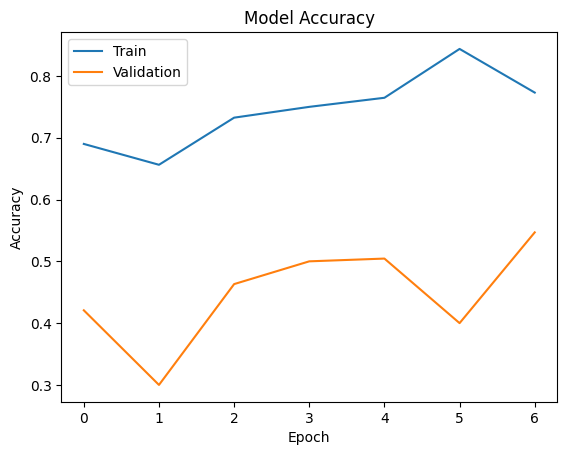

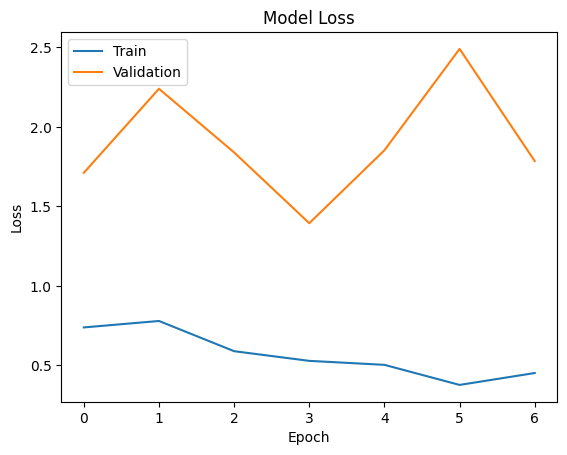

In [22]:
# Plot accuracy dan val_accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot loss dan val_loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Prediction: Attack
Confidence score: 0.9986


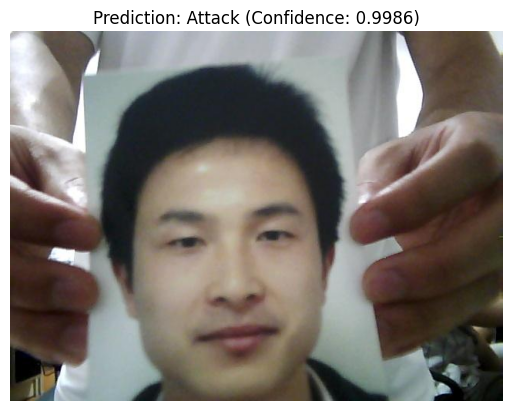

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Prediction: Liveness
Confidence score: 0.9932


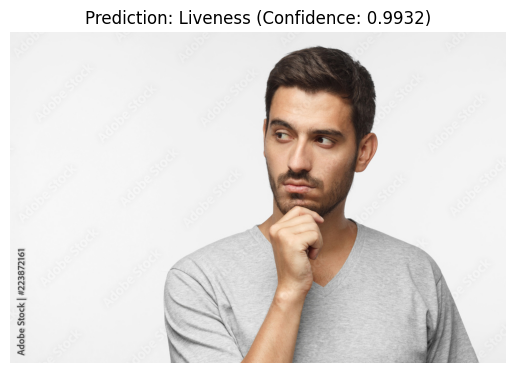

In [ ]:
# Load the saved model
model = tf.keras.models.load_model('../model_download/front_facing/model_front_facing.keras')

# Function to preprocess an image for prediction
def preprocess_image(image_path):
  img = load_img(image_path, target_size=(224, 224))
  img_array = img_to_array(img)
  img_array = np.expand_dims(img_array, axis=0)
  # img_array /= 255.  # Normalize the image if your model expects normalized input
  return img_array

# Function to predict and display results
def predict_image(image_path):
  preprocessed_image = preprocess_image(image_path)
  prediction = model.predict(preprocessed_image)

  if prediction[0][0] > 0.5:
    label = "Liveness"
  else:
    label = "Attack"

  confidence = prediction[0][0] if label == "Liveness" else 1 - prediction[0][0]

  print(f"Prediction: {label}")
  print(f"Confidence score: {confidence:.4f}")
  img = mpimg.imread(image_path)
  plt.imshow(img)
  plt.title(f"Prediction: {label} (Confidence: {confidence:.4f})")
  plt.axis('off')
  plt.show()


# Example usage:
test_image_path1 = "../datasets/test/test/0001_00_01_03_77.jpg"
test_image_path2 = "../datasets/test/test/1000_F_223872161_YZ98dGUBv8Oh7ce3WgF4JRbT9u07Nv4m.jpg"


predict_image(test_image_path1)
predict_image(test_image_path2)

In [41]:
import time

# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Fungsi untuk mengukur latensi
def measure_latency(image_path, model, num_runs=100):
    preprocessed_image = preprocess_image(image_path)
    
    # Warm-up
    for _ in range(10):
        _ = model.predict(preprocessed_image)
    
    # Mengukur latensi
    start_time = time.time()
    for _ in range(num_runs):
        _ = model.predict(preprocessed_image)
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average latency over {num_runs} runs: {avg_latency:.6f} seconds")

# Contoh penggunaan
test_image_path = "../datasets/test/test/0001_00_01_03_77.jpg"
measure_latency(test_image_path, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━

In [45]:
# Fungsi untuk memuat dan memproses gambar
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.mobilenet_v3.preprocess_input(img_array)
    return img_array

# Mengonversi model ke TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Menyimpan model TFLite ke file
tflite_model_path = '../model_download/front_facing/model_front_facing.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)

# Mengukur latensi model TFLite
def measure_tflite_latency(image_path, tflite_model_path, num_runs=100):
    # Memuat model TFLite
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Mendapatkan ukuran input yang diharapkan
    input_shape = input_details[0]['shape'][1:3]
    
    preprocessed_image = preprocess_image(image_path, target_size=input_shape)
    
    # Warm-up
    for _ in range(10):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    
    # Mengukur latensi
    start_time = time.time()
    for _ in range(num_runs):
        interpreter.set_tensor(input_details[0]['index'], preprocessed_image)
        interpreter.invoke()
    end_time = time.time()
    
    avg_latency = (end_time - start_time) / num_runs
    print(f"Average TFLite latency over {num_runs} runs: {avg_latency:.6f} seconds")

# Contoh penggunaan
test_image_path = "../datasets/test/test/0001_00_01_03_77.jpg"
measure_tflite_latency(test_image_path, tflite_model_path)

INFO:tensorflow:Assets written to: /tmp/tmpkr_h0f1x/assets


INFO:tensorflow:Assets written to: /tmp/tmpkr_h0f1x/assets


Saved artifact at '/tmp/tmpkr_h0f1x'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140468491612784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491639744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491641856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491635168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491637456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491647312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491698592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491698944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491648368: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468491698768: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14046849170

W0000 00:00:1732211652.082296   18867 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732211652.082352   18867 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 00:54:12.082575: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpkr_h0f1x
2024-11-22 00:54:12.092507: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 00:54:12.092537: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpkr_h0f1x
2024-11-22 00:54:12.190548: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 00:54:12.704010: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpkr_h0f1x
2024-11-22 00:54:12.840765: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 758199 microseconds.


Average TFLite latency over 100 runs: 0.000536 seconds


In [48]:
# Memuat model Keras
model = tf.keras.models.load_model('../model_download/front_facing/pertama/model_front_facing.keras')

# Mengonversi model ke TFLite dengan kuantisasi rentang dinamis
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model_quant = converter.convert()

# Menyimpan model TFLite yang telah dikuantisasi ke file
tflite_model_quant_path = '../model_download/front_facing/model_front_facing_quant.tflite'
with open(tflite_model_quant_path, 'wb') as f:
    f.write(tflite_model_quant)

print("Model TFLite dengan kuantisasi rentang dinamis telah disimpan.")

INFO:tensorflow:Assets written to: /tmp/tmpa1b_kypn/assets


INFO:tensorflow:Assets written to: /tmp/tmpa1b_kypn/assets


Saved artifact at '/tmp/tmpa1b_kypn'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, None, 3), dtype=tf.float32, name='input_layer_3')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  140468258295648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468258306032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468257882352: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468258301456: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468258303744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468258304976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468257889040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468257892032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468257888688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140468257889392: TensorSpec(shape=(), dtype=tf.resource, name=None)
  14046825789

W0000 00:00:1732213136.952722   18867 tf_tfl_flatbuffer_helpers.cc:365] Ignored output_format.
W0000 00:00:1732213136.952829   18867 tf_tfl_flatbuffer_helpers.cc:368] Ignored drop_control_dependency.
2024-11-22 01:18:56.953772: I tensorflow/cc/saved_model/reader.cc:83] Reading SavedModel from: /tmp/tmpa1b_kypn
2024-11-22 01:18:56.964470: I tensorflow/cc/saved_model/reader.cc:52] Reading meta graph with tags { serve }
2024-11-22 01:18:56.964505: I tensorflow/cc/saved_model/reader.cc:147] Reading SavedModel debug info (if present) from: /tmp/tmpa1b_kypn
2024-11-22 01:18:57.073605: I tensorflow/cc/saved_model/loader.cc:236] Restoring SavedModel bundle.
2024-11-22 01:18:57.605377: I tensorflow/cc/saved_model/loader.cc:220] Running initialization op on SavedModel bundle at path: /tmp/tmpa1b_kypn
2024-11-22 01:18:57.740395: I tensorflow/cc/saved_model/loader.cc:466] SavedModel load for tags { serve }; Status: success: OK. Took 786627 microseconds.


Model TFLite dengan kuantisasi rentang dinamis telah disimpan.
